In [6]:
import os
import sys
import gin
import numpy as np
import pandas as pd
from IPython.core.display import clear_output, display
from ariadne.graph_net.graph_utils.graph_prepare_utils import to_pandas_graph_from_df, get_pd_line_graph, \
    apply_nodes_restrictions, apply_edge_restriction, construct_output_graph
from ariadne.transformations import Compose, ConstraintsNormalize, ToCylindrical
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
from prepare import parse

csv_params = {
"sep": '\s+',
#"nrows": 15000,
"encoding": 'utf-8',
"names": ['event',  'x', 'y', 'z', 'station', 'track', 'px', 'py', 'pz', 'X0', 'Y0', 'Z0']
}
suff_df = ('_p', '_c')
gin.bind_parameter('get_pd_line_graph.restrictions_0',(-0.2, 0.2))
gin.bind_parameter('get_pd_line_graph.restrictions_1', (-0.28, 0.28))
gin.bind_parameter('get_pd_line_graph.suffix_c', '_c')
gin.bind_parameter('get_pd_line_graph.suffix_p','_p')
gin.bind_parameter('get_supernodes_df.suffix_c', '_c')
gin.bind_parameter('get_supernodes_df.suffix_p', '_p')
gin.bind_parameter('get_supernodes_df.axes', ['r', 'phi', 'z'])
gin.bind_parameter('apply_edge_restriction.edge_restriction', 0.093)
stations_constraints = {
    0: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    1: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    2: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
}

In [277]:
events = parse("../data/new_data/1.txt", csv_params=csv_params, events_quantity='0..1000')
events = next(events)[0]
n_events = 1000
events_to_analyze = events[events.event < n_events]

In [278]:
from collections import namedtuple
GraphWithIndices = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y', 'v', 'v_from_to','e_from_to', 'ev_id' ])

def construct_graph_with_indices(graph, v_inds, v_from_to, e_from_to, ev_id):
    return GraphWithIndices(graph.X, graph.Ri, graph.Ro, graph.y, v_inds, v_from_to, e_from_to, ev_id)

In [279]:
nodes = pd.DataFrame()
edges = pd.DataFrame()

graphs = {}

for idx, event in events_to_analyze.groupby('event'):
    clear_output(wait=True)
    display("Event #%09d" % idx)
    
    transformer = Compose([
            ConstraintsNormalize(
                use_global_constraints=False,
                constraints=stations_constraints
            ),
            ToCylindrical(drop_old=True, cart_columns=('y', 'x'))
        ])
    try:
        event = transformer(event)
    except AssertionError as err:
        print("ASS error %r" % err)
        continue
    G = to_pandas_graph_from_df(event, suffixes=suff_df, compute_is_true_track=True)
    nodes_t, edges_t = get_pd_line_graph(G, apply_nodes_restrictions)
    edges_filtered = apply_edge_restriction(edges_t)
    graph = construct_output_graph(nodes_t, edges_filtered, ['y_p', 'y_c', 'z_p', 'z_c', 'z'],
                                     [np.pi, np.pi, 1., 1., 1.], 'edge_index_p', 'edge_index_c')
    ev_id = event.event.values[0]
    graph_with_inds = construct_graph_with_indices(graph, 
                                                   nodes_t.index.values, 
                                                   nodes_t[['from_ind','to_ind']].values,
                                                   edges_filtered[['edge_index_p','edge_index_c']].values,
                                                   ev_id)
    np.testing.assert_allclose(graph_with_inds.X, 
                               nodes_t[['y_p', 'y_c', 'z_p', 'z_c', 'z']].values/[np.pi, np.pi, 1., 1., 1.])
    assert ev_id not in graphs
    graphs[ev_id] = graph_with_inds
    
    

'Event #000000999'

In [280]:
from ariadne.graph_net.model import GraphNet_v1
import torch

gin.bind_parameter('GraphNet_v1.input_dim', 5)
gin.bind_parameter('GraphNet_v1.hidden_dim', 128)
gin.bind_parameter('GraphNet_v1.n_iters', 1)

def weights_update(model, checkpoint):
    model_dict = model.state_dict()    
    pretrained_dict =  checkpoint['state_dict']
    real_dict = {}
    for (k,v) in model_dict.items():
        needed_key = None
        for pretr_key in pretrained_dict:
            if k in pretr_key:
                needed_key = pretr_key
                break
        assert needed_key is not None, "key %s not in pretrained_dict %r!" % (k, pretrained_dict.keys())
        real_dict[k] = pretrained_dict[needed_key]

    model.load_state_dict(real_dict)
    model.eval()
    return model

path = '../lightning_logs/version_hydra_63115/checkpoints/epoch=49.ckpt'
checkpoint = torch.load(path) if torch.cuda.is_available() else torch.load(path, map_location=torch.device('cpu'))
model = weights_update(model=GraphNet_v1(), 
                       checkpoint=checkpoint)


In [281]:
from ariadne.graph_net.dataset import GraphDatasetFromMemory, collate_fn
from ariadne.graph_net.data_loader import GraphDataLoader

graphs_list = list(graphs.values())

gin.bind_parameter('GraphDatasetFromMemory.input_graphs', graphs_list)

data_loader = GraphDataLoader(
    batch_size=1,
    dataset=GraphDatasetFromMemory,
    collate_fn=collate_fn,
    n_train=0,
    n_valid=len(graphs_list)-1    
).get_val_dataloader()

In [282]:
with torch.no_grad():
    test_outputs = [(model(batch_input).flatten(), batch_target.flatten())
                    for (batch_input, batch_target) in data_loader]
    test_pred, test_target = zip(*test_outputs)
    test_pred = np.concatenate(test_pred)
    test_target = np.concatenate(test_target)


In [283]:
import sklearn.metrics
thresh = 0.5
y_pred, y_true = (test_pred > thresh), (test_target > thresh)
print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(y_true, y_pred))
print('Precision: %.4f' % sklearn.metrics.precision_score(y_true, y_pred))
print('Recall:    %.4f' % sklearn.metrics.recall_score(y_true, y_pred))

Test set results with threshold of 0.5
Accuracy:  0.9792
Precision: 0.9064
Recall:    0.9623


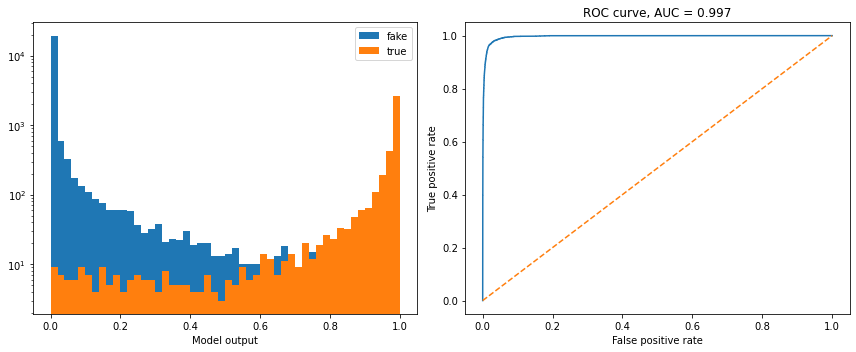

In [284]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, test_pred)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the model outputs
binning=dict(bins=50, range=(0,1), histtype='bar', log=True)
ax0.hist(test_pred[y_true==False], label='fake', **binning)
ax0.hist(test_pred[y_true], label='true', **binning)
ax0.set_xlabel('Model output')
ax0.legend(loc=0)

# Plot the ROC curve
auc = sklearn.metrics.auc(fpr, tpr)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], '--')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title('ROC curve, AUC = %.3f' % auc)

plt.tight_layout()

In [285]:
from itertools import chain

total_tracks_inds = []
reco_tracks_inds = []

total_events = 0

total_tracks = 0
total_tracks_true = 0
total_events_true = 0
total_hits = 0
total_hits_true = 0

total_hits_inds = []
reco_hits_inds = []

for idx, event in events_to_analyze.groupby('event'):
    ev_id_real = event.event.values[0]
    clear_output(wait=True)
    display("Event #%09d" % idx)
    hits_in_event = set()
    for tr_id, track in event.groupby('track'):
        if tr_id != -1:
            total_tracks_inds.append(track.index.values)
            hits_in_event.update(track.index.values)
    total_hits_inds.extend(hits_in_event)
    tracks_in_event = event[event.track != -1].track.nunique()
    total_tracks += tracks_in_event
    total_hits += len(hits_in_event)
    total_events += 1
    if ev_id_real not in graphs:
        continue
    graphed_event = event[['event', 'x', 'y','z','track', 'station']]
    G = to_pandas_graph_from_df(graphed_event, suffixes=suff_df, compute_is_true_track=True)

    tgt_graph = graphs[ev_id_real]
    batch_input, batch_target = collate_fn([tgt_graph])
    with torch.no_grad():
        y_pred = model(batch_input).numpy().flatten() > 0.5
    
    superedge_pred = tgt_graph.e_from_to[y_pred]
    edges_pred = [G.loc[pred]
                  for pred in superedge_pred]

    edge_ind_pred = [(edgs.iloc[0].index_old_p, 
                      edgs.iloc[0].index_old_c, 
                      edgs.iloc[1].index_old_c) for edgs in edges_pred]
    hits_pred = set(chain.from_iterable(edge_ind_pred))
    found_hits = hits_pred.intersection(hits_in_event)
    total_hits_true += len(found_hits)
    reco_hits_inds.extend(found_hits)
    reco_tracks = 0
    for tr in total_tracks_inds:
        for tr_pred in edge_ind_pred:
            if len(tr) == len(tr_pred) and np.allclose(tr, tr_pred):
                total_tracks_true += 1
                reco_tracks += 1
                break

    if reco_tracks == tracks_in_event:
        total_events_true += 1

'Event #000000999'

In [286]:
print("Total track efficiency: %.04f" % (total_tracks_true / total_tracks))
print("Total hit efficiency: %.04f" % (total_hits_true / total_hits))
print("Total event efficiency: %.04f" % (total_events_true / total_events))

Total track efficiency: 0.8881
Total hit efficiency: 0.9231
Total event efficiency: 0.6690


In [287]:
from numpy import linalg as LA

events_to_analyze['mean_p'] = LA.norm(events_to_analyze[['px','py','pz']].values, axis=1)

all_real_hits = events_to_analyze[events_to_analyze.track != -1]

assert(len(all_real_hits) == len(total_hits_inds))

all_real_hits['found'] = False
all_real_hits.loc[reco_hits_inds, 'found'] = True
found_hits = all_real_hits[all_real_hits.found]


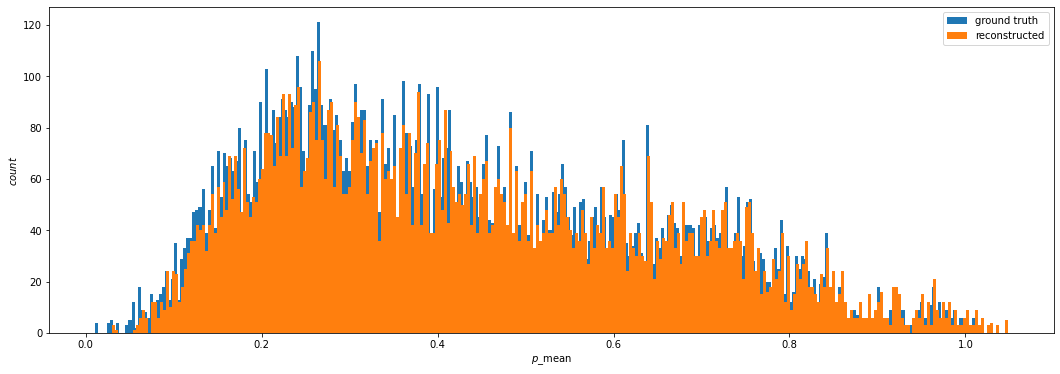

In [288]:
plt.figure(figsize=(18,6))

plt.subplot(111)
binning=dict(bins=300)
plt.hist(all_real_hits['mean_p'], label='ground truth', log=False, **binning)
plt.hist(found_hits['mean_p'], label='reconstructed', log=False, **binning)
plt.ylabel('$count$')
plt.xlabel('$p$_mean')
plt.legend(loc=0)

In [325]:
start = all_real_hits.mean_p.min()
end = all_real_hits.mean_p.max()

def get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num):
    spac = np.linspace(start, end, num=num)
    
    arr = [0]
    
    for i in range(len(spac)-1):
        beg = spac[i]
        end = spac[i+1]
        elems_real = all_real_hits[(all_real_hits.mean_p > beg) &(all_real_hits.mean_p < end)]
        elems_pred = found_hits[(all_real_hits.mean_p > beg) &(all_real_hits.mean_p < end)]
        if elems_real.empty:
            arr.append(np.NaN)
            continue
        arr.append(len(elems_pred) / len(elems_real))
    return arr, spac


In [370]:
initial, spac = get_diagram_arr_linspace(all_real_hits, found_hits, start, end, 150)

from scipy.interpolate import make_interp_spline, BSpline
second, spac2 = get_diagram_arr_linspace(all_real_hits, found_hits, start, end, 25)

xnew = np.linspace(spac2.min(), spac2.max(), 30) 

spl = make_interp_spline(spac2, second, k=3)  # type: BSpline
power_smooth = spl(xnew)


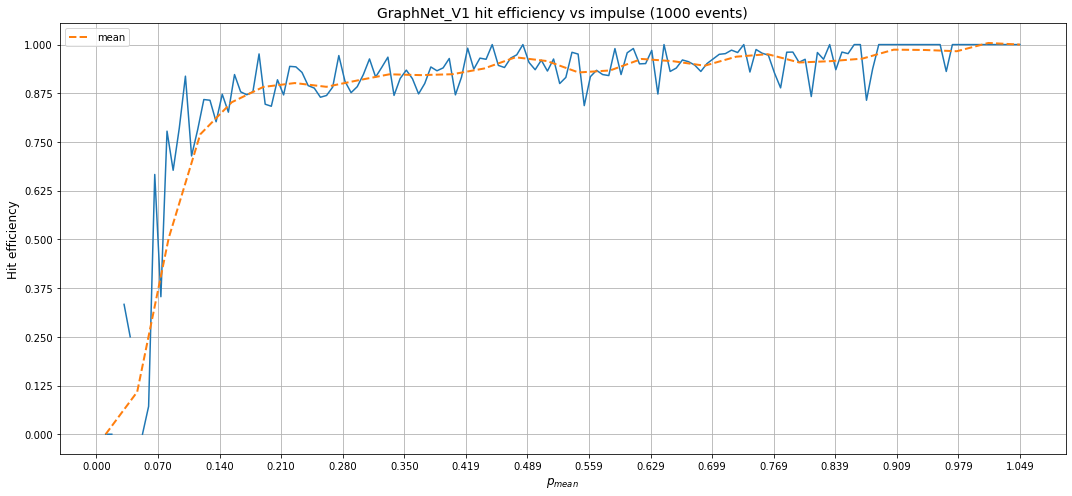

In [371]:
maxX = end
plt.figure(figsize=(15,7))

plt.subplot(111)
plt.ylabel('Hit efficiency', fontsize=12)
plt.xlabel('$p_{mean}$', fontsize=12)
#plt.axis([0, maxX, 0, 1.005])
plt.plot(spac, arr)
plt.title('GraphNet_V1 hit efficiency vs impulse (1000 events)', fontsize=14)
plt.plot(xnew, power_smooth, ls='--', label='mean', lw=2)
plt.xticks(np.linspace(0, maxX, 16))
plt.yticks(np.linspace(0, 1, 9))
plt.legend(loc=0)
plt.grid()
plt.tight_layout()
plt.show()

In [18]:
def draw_single(X, Ri, Ro, y, c_true = 'green', c_fake = (0,0,0,0.1), xcord1 = (2, 'x'), xcord2 = (1, 'y'), ycord=(0, 'z'), draw_fake=True):
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    #                0    1  2  3  4  5
    # Draw the hits (r, phi, z, x, y, z)
    # colMap = np.zeros_like(X)
    # colMap[:, 0] = X[:, 0]*1.7 + 100
    # colMap *= 1.0 / colMap.max()
    ax0.scatter(X[:, xcord1[0]],
                X[:, ycord[0]], c='black')
    ax1.scatter(X[:, xcord2[0]],
                X[:, ycord[0]], c='black')

    # Draw the segments
    for j in range(y.shape[0]):
        ax0.plot([feats_o[j, xcord1[0]], feats_i[j, xcord1[0]]],
                 [feats_o[j, ycord[0]], feats_i[j, ycord[0]]], '-', c=c_true if y[j] > 0.5 else c_fake, zorder=10 if y[j] > 0.5 else 1)
        ax1.plot([feats_o[j, xcord2[0]], feats_i[j, xcord2[0]]],
                 [feats_o[j, ycord[0]], feats_i[j, ycord[0]]], '-', c=c_true if y[j] > 0.5 else c_fake, zorder=10 if y[j] > 0.5 else 1)
    # Adjust axes
    ax0.set_xlabel('$%s$' % xcord1[1])
    ax0.set_ylabel('$%s$' % ycord[1])

    ax1.set_xlabel('$%s$' % xcord2[1])
    ax1.set_ylabel('$%s$' % ycord[1])
    plt.tight_layout()
    plt.show()

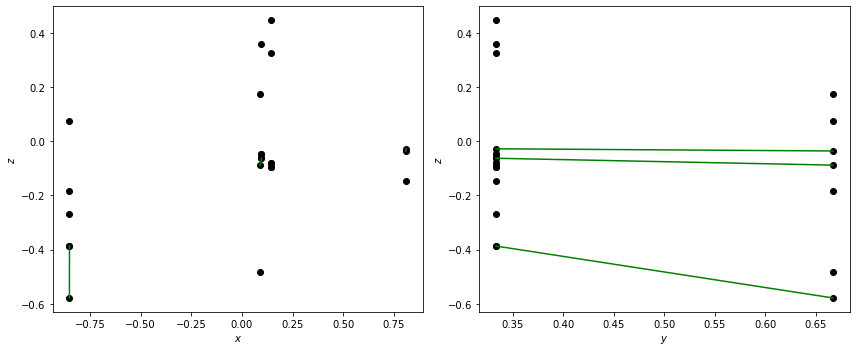

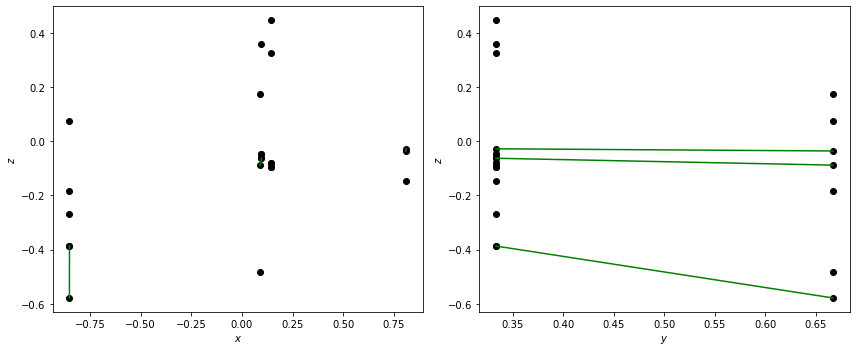

In [13]:

n_draw = 123

X, Ri, Ro, y = data_loader.dataset[n_draw]
pred = test_outputs[n_draw][0].numpy()
draw_single(X, Ri, Ro, pred, c_fake=(0,0,0,0.0), xcord1=(0, 'x'), xcord2=(4, 'y'), ycord=(2, 'z'))
draw_single(X, Ri, Ro, y, c_fake=(0,0,0,0.0), xcord1=(0, 'x'), xcord2=(4, 'y'), ycord=(2, 'z'))
